# Final Project: Predicting Photo Downloads

In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_blobs, make_circles, make_classification, fetch_olivetti_faces
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from statistics import mode
import statsmodels.api as sm

%matplotlib inline

In [2]:
def forward(X, y, predictors, response_variable):
    
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(X, y, predictors + [p], response_variable))

    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest acc
    best_model = models.loc[models['acc'].argmax()]
    acc = models['acc'].max()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors")
    
    # Return the best model, along with some other useful information about the model
    return best_model, acc

In [3]:
def processSubset(X, y, predictor_variables, response_variable):
    # Fit model on feature_set and calculate accuracy

    log_reg = sm.Logit(y,X[list(predictor_variables)]).fit()
    preds = log_reg.predict(X_val[predictor_variables])
    binary_preds = np.where(preds >= .5, 1, 0)
    acc = accuracy_score(y_val, binary_preds)
    
    return {"model":log_reg, "acc":acc}

# Data Preprocessing

In [64]:
df = pd.read_csv('Photo_Sales.csv')
df.head()

,PhotoID,PhotographerID,EventID,Latitude,Longitude,Price,ErrorID,Tagged,Riders,Stage,...,Horizontal,Vertical,Gender,BuyRating,Red,Green,Blue,OldName,DateTime,PriceID
0,2,1,1,NaN,NaN,10.0,NaN,1,0.0,e,...,f,m,m,1.0,74.0,63.0,58.0,NaN,NaN,NaN
1,3,2,2,0.0,0.0,1.0,NaN,1,0.0,e,...,d,m,m,1.0,99.0,93.0,83.0,NaN,NaN,NaN
2,4,2,2,0.0,0.0,1.0,NaN,1,2.0,e,...,f,m,m,1.0,91.0,86.0,84.0,NaN,NaN,NaN
3,5,2,2,0.0,0.0,1.0,NaN,1,1.0,d,...,f,m,m,1.0,107.0,104.0,106.0,NaN,NaN,NaN
4,6,2,2,0.0,0.0,1.0,NaN,1,3.0,d,...,d,l,m,1.0,68.0,76.0,84.0,NaN,NaN,NaN


In [65]:
df.columns

Index(['PhotoID', 'PhotographerID', 'EventID', 'Latitude', 'Longitude',
       'Price', 'ErrorID', 'Tagged', 'Riders', 'Stage', 'Obstacle', 'Blur',
       'Horizontal', 'Vertical', 'Gender', 'BuyRating', 'Red', 'Green', 'Blue',
       'OldName', 'DateTime', 'PriceID'],
      dtype='object')

In [66]:
df.drop(['Latitude','Longitude','ErrorID','Price','OldName','PhotoID','PhotographerID','EventID','PriceID','DateTime','Tagged'],axis=1, inplace=True)

In [83]:
df = df.dropna()
X = df.drop(['BuyRating'],axis=1)
X = pd.get_dummies(data=X, drop_first=True)
X[['Riders','Blur','Red','Green','Blue']] = (X[['Riders','Blur','Red','Green','Blue']] - X[['Riders','Blur','Red','Green','Blue']].mean()) / X[['Riders','Blur','Red','Green','Blue']].std()
y = df.BuyRating
y = pd.DataFrame(data=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=50)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(452, 16) (452, 1)
(97, 16) (97, 1)
(97, 16) (97, 1)


In [68]:
X

,Riders,Blur,Red,Green,Blue,Stage_e,Stage_f,Stage_s,Stage_u,Obstacle_y,Horizontal_d,Horizontal_f,Horizontal_s,Vertical_l,Vertical_m,Gender_m
0,0.0,552.0,74.0,63.0,58.0,1,0,0,0,0,0,1,0,0,1,1
1,0.0,1595.0,99.0,93.0,83.0,1,0,0,0,0,1,0,0,0,1,1
2,2.0,420.0,91.0,86.0,84.0,1,0,0,0,0,0,1,0,0,1,1
3,1.0,928.0,107.0,104.0,106.0,0,0,0,0,1,0,1,0,0,1,1
4,3.0,620.0,68.0,76.0,84.0,0,0,0,0,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,2.0,3359.0,106.0,97.0,74.0,0,0,0,0,0,0,1,0,0,1,1
642,1.0,1973.0,116.0,104.0,86.0,0,0,0,0,0,0,1,0,0,1,1
643,2.0,1607.0,122.0,115.0,95.0,1,0,0,0,0,0,1,0,0,1,1
644,1.0,2678.0,106.0,95.0,80.0,0,0,0,0,0,0,1,0,0,1,1


## Set baseline accuracy

In [86]:
target_acc = y['BuyRating'].mean()
target_acc

0.37925696594427244

In [87]:
target_acc = 1 - target_acc
target_acc

0.6207430340557276

We will use the Majority Class Classifier as the baseline accuracy to beat.

# Logistic Regression

Logistic Regression assumptions are that the output variable be binary, observations be independent of each other, little or no multicolinearity of predictors, and a large sample size.

Display correlation matrix to check for multicolinearity.

In [123]:
cor_matrix = cv_df.corr()
cor_matrix.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)

,Riders,Blur,Red,Green,Blue,Stage_e,Stage_f,Stage_s,Stage_u,Obstacle_y,Horizontal_d,Horizontal_f,Horizontal_s,Vertical_l,Vertical_m,Gender_m,BuyRating
Riders,1.000000,-0.076952,0.080008,0.102634,0.120420,-0.051969,-0.046712,0.590417,-0.118251,-0.055936,0.052407,0.080858,-0.153111,-0.114759,0.076288,0.083471,0.168296
Blur,-0.076952,1.000000,-0.280269,-0.271304,-0.336423,-0.351761,-0.258045,-0.057462,0.082241,-0.171535,0.165755,0.001991,-0.169029,-0.127475,0.049135,-0.268660,0.069420
Red,0.080008,-0.280269,1.000000,0.968297,0.899386,0.251006,-0.156867,0.003002,-0.057557,0.134995,-0.033722,0.057269,0.000625,-0.034685,0.080512,0.165643,-0.046713
Green,0.102634,-0.271304,0.968297,1.000000,0.969196,0.238472,-0.147497,-0.029975,-0.023051,0.073749,-0.016385,0.033932,0.013069,0.005769,0.044204,0.122118,-0.046977
Blue,0.120420,-0.336423,0.899386,0.969196,1.000000,0.230714,-0.082505,-0.033930,0.008478,0.058309,0.001012,-0.005601,0.034942,0.035101,0.018091,0.108048,-0.052986
Stage_e,-0.051969,-0.351761,0.251006,0.238472,0.230714,1.000000,-0.229628,-0.201722,-0.271175,0.170007,-0.048517,-0.093799,0.124116,0.089546,-0.088290,0.119147,-0.082162
Stage_f,-0.046712,-0.258045,-0.156867,-0.147497,-0.082505,-0.229628,1.000000,-0.160977,-0.216401,-0.138800,-0.092041,0.189159,-0.125056,-0.033538,0.047169,0.126945,-0.005156
Stage_s,0.590417,-0.057462,0.003002,-0.029975,-0.033930,-0.201722,-0.160977,1.000000,-0.190103,-0.121932,0.107707,0.031855,-0.155498,-0.143881,0.105073,0.119078,0.111035
Stage_u,-0.118251,0.082241,-0.057557,-0.023051,0.008478,-0.271175,-0.216401,-0.190103,1.000000,0.210651,0.113063,-0.333999,0.304465,0.144193,-0.075064,-0.253037,-0.067844
Obstacle_y,-0.055936,-0.171535,0.134995,0.073749,0.058309,0.170007,-0.138800,-0.121932,0.210651,1.000000,-0.099049,-0.154061,0.314356,0.191595,-0.156887,0.135263,0.002495


In [89]:
models_fwd = pd.DataFrame(columns=["model", "AIC", "BIC", "acc"])

predictors = []
acc = []

for i in range(1,len(X_train.columns)+1):   
    models_fwd.loc[i], models_fwd.loc[i, 'acc'] = forward(X_train, y_train, predictors, 'BuyRating')
    predictors = models_fwd.loc[i]["model"].model.exog_names
    models_fwd.loc[i, 'AIC'] = models_fwd.loc[i, 'model'].aic
    models_fwd.loc[i, 'BIC'] = models_fwd.loc[i, 'model'].bic

Optimization terminated successfully.
         Current function value: 0.678583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692121
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692088
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691804
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692831
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691048
  

Optimization terminated successfully.
         Current function value: 0.649917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650654
         Iterations 5
Processed  10 models on 7 predictors
Optimization terminated successfully.
         Current function value: 0.649136
         Iterations 5
Optimization terminated successfully.
       

9


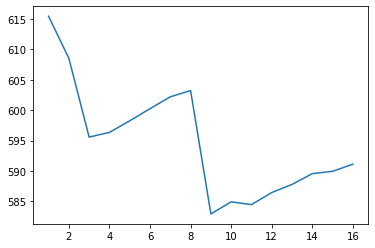

In [90]:
print(np.argmin(models_fwd['AIC']) + 1)
plt.plot(np.arange(len(models_fwd)) + 1,models_fwd['AIC'])

3


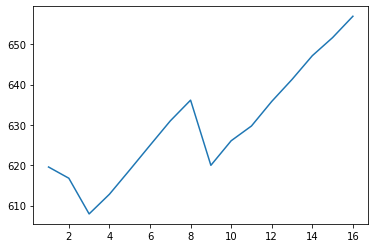

In [91]:
print(np.argmin(models_fwd['BIC']) + 1)
plt.plot(np.arange(len(models_fwd)) + 1,models_fwd['BIC'])

12


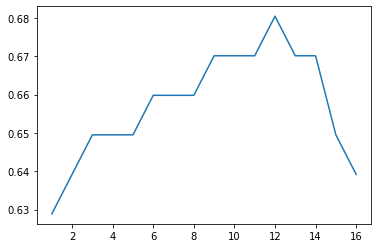

In [92]:
print(np.argmax(models_fwd['acc']) + 1)
plt.plot(np.arange(len(models_fwd)) + 1,models_fwd['acc'])

Train a model with the optimal predictors based on AIC. BIC will return a model with too much error and it will not describe with enough variables. Making a model from the maximum accuracy will cause the model to be too complex, and will lead to an excessive number of non-statistically sigificant predictors.

In [101]:
log_reg = models_fwd.loc[np.argmin(models_fwd['AIC']) + 1, 'model']
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              BuyRating   No. Observations:                  452
Model:                          Logit   Df Residuals:                      443
Method:                           MLE   Df Model:                            8
Date:                Sat, 06 Aug 2022   Pseudo R-squ.:                 0.06650
Time:                        19:06:12   Log-Likelihood:                -282.47
converged:                       True   LL-Null:                       -302.59
Covariance Type:            nonrobust   LLR p-value:                 2.884e-06
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Riders           0.3212      0.127      2.533      0.011       0.073       0.570
Stage_u         -0.1663      0.273     -0.610      0.542      -0.700       0.368
Gender_m        -0.4439      0.223     -1.989      0.047      -0.881      -0.006
Red             -0.1537      0.107     -1.431      0.153      -0.364       0.057
Stage_f         -0.1276      0.296     -0.431      0.667      -0.708       0.453
Stage_s         -0.0455      0.383     -0.119      0.905      -0.797       0.706
Vertical_m       0.1416      0.217      0.653      0.514      -0.284       0.567
Obstacle_y       0.8714      0.406      2.147      0.032       0.076       1.667
Horizontal_s    -1.7206      0.416     -4.135      0.000      -2.536      -0.905
================================================================================
"""

Each assumption of logistic regression is met. While there is multicolinearity in the dataset, there is no significant multicolinearity within this model.

##### Interpretation of Coefficients:

STAGE

The stage of the race is not statistically significant, however, the log-odds of the photo being downloaded may decrease by between .04 and .16 when the stage is anything but downhill.

GENDER

Male riders are .4439 log odds less likely to download a photo.

RED

The amount of red is not statistically significant, but as the amount of red increases by one standard deviation, it may be that the chance of the photo being downloaded decreases by .1537 log odds. Each color has a similar effect, as 'Red', 'Green', and 'Blue' all share high colinearity. Less stark colors in a photo leads to greater likely of that photo being downloaded.

RIDERS

The number of Riders is statistically significant. For each standard deviation that the number of riders increases, the log odds of a photo being sold increases by .3212.

VERTICAL

Vertical is not statistically significant, but the vertical angle being mid-height may lead to a .1416 increase in the log odds of the photo being downloaded.

OBSTACLE

It is statistically significant that the log odds of a photo being downloaded will increase by .8714 when the rider is going over an obstacle.

HORIZONTAL

It is statistically sicnificant that when a photo is taken from a side angle to the rider, the log odds of the photo being downloaded will decrease by 1.7206

Use 10-fold cross validation to find the optimal threshold value for logistic regression model.

In [17]:
cv_df = pd.concat([X_train,y_train],axis=1)
cv_df.reset_index(inplace=True,drop=True)

thresholds = np.linspace(0,1,10)
acc_list = []

folds = np.random.choice(a = 10, size = cv_df.shape[0])

for thresh in thresholds:
    bin_pred_list = []
    yval_list = []
    for i in range(10):
        val = cv_df.iloc[np.where(folds == i)[0],:]
        train = cv_df.iloc[np.where(folds != i)[0],:]

        Xtrain = train.drop(['BuyRating'],axis=1)
        ytrain = train[['BuyRating']]
        Xtrain = sm.add_constant(Xtrain, has_constant='add')
        logreg = sm.Logit(ytrain, Xtrain).fit()

        Xval = val.drop(['BuyRating'],axis=1)
        yval = val[['BuyRating']]
        Xval = sm.add_constant(Xval, has_constant='add')
        val_preds = logreg.predict(Xval.apply(pd.to_numeric))
    
        binary_preds = np.where(val_preds >= thresh, 1, 0)
        bin_pred_list.extend(binary_preds)
        yval_list.extend(yval['BuyRating'].tolist())
    acc_list.append(accuracy_score(yval_list, bin_pred_list))

Optimization terminated successfully.
         Current function value: 0.618974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.617187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.620961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.617005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.611588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.600061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.605198
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.611901
  

Optimization terminated successfully.
         Current function value: 0.620961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.617005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.611588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.600061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.605198
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.611901
         Iterations 6


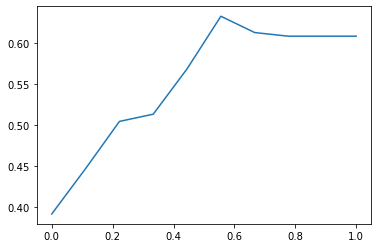

In [18]:
plt.plot(thresholds, acc_list)

Find validation accuracy for logistic regression model

In [19]:
predictors = models_fwd.loc[np.argmax(models_fwd['acc']) + 1, 'model'].model.exog_names
preds = log_reg.predict(X_val[predictors])

In [20]:
preds

637    0.394004
168    0.461411
11     0.491434
430    0.199414
544    0.487199
         ...   
67     0.454671
145    0.486950
574    0.501264
463    0.299785
587    0.504648
Length: 97, dtype: float64

In [21]:
print("Optimal Threshold: ", thresholds[np.argmax(acc_list)])
binary_preds = np.where(preds >= thresholds[np.argmax(acc_list)], 1, 0)

accuracy_score(y_val, binary_preds)

Optimal Threshold:  0.5555555555555556


0.6701030927835051

# Decision Tree

Train a decion tree to full depth.

In [22]:
clf = DecisionTreeClassifier().fit(X_train, y_train)
train_acc = clf.score(X_train,y_train)
val_acc = clf.score(X_val, y_val)

print(f'Training Accuracy: {train_acc}')
print(f'Val Accuracy: {val_acc}')

Training Accuracy: 1.0
Val Accuracy: 0.5979381443298969


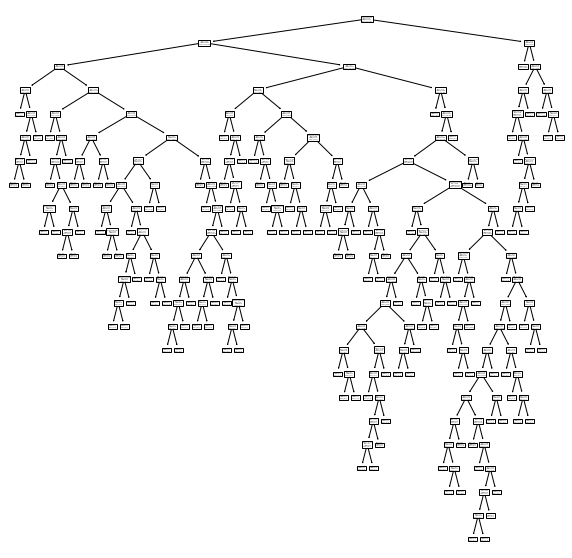

In [23]:
plt.figure(figsize=(10, 10))
plot_tree(clf, feature_names=X.columns)
plt.show()

Perform Cost Complexity Pruning.

Text(0, 0.5, 'total impurity of leaves')

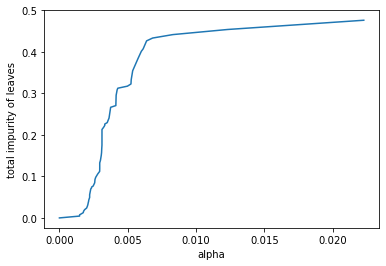

In [24]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.plot(ccp_alphas, impurities)
plt.xlabel("alpha")
plt.ylabel("total impurity of leaves")

In [25]:
clfs = []
dt_acc_list = []
folds = np.random.choice(a = 10, size = cv_df.shape[0])

for ccp_alpha in ccp_alphas[:-1]:
    fold_accuracies = []
    for i in range(10):
        val = cv_df.iloc[np.where(folds == i)[0],:]
        train = cv_df.iloc[np.where(folds != i)[0],:]

        Xtrain = train.drop(['BuyRating'],axis=1)
        ytrain = train[['BuyRating']]
        clf = DecisionTreeClassifier(random_state=50, ccp_alpha=ccp_alpha)
        clf.fit(Xtrain, ytrain)

        Xval = val.drop(['BuyRating'],axis=1)
        yval = val[['BuyRating']]

        fold_accuracies.append(clf.score(Xval, yval))
    dt_acc_list.append(np.mean(fold_accuracies))
    clfs.append(clf)

print(clfs[np.argmax(dt_acc_list)])

DecisionTreeClassifier(ccp_alpha=0.006131108400591698, random_state=50)


Text(0, 0.5, 'Accuracy scores')

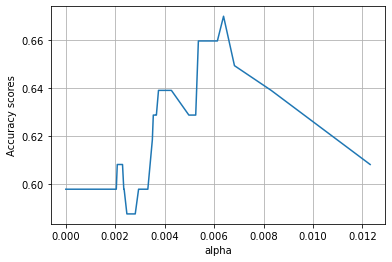

In [26]:
acc_scores = [clf.score(X_val, y_val) for clf in clfs]

plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores)
plt.xlabel("alpha")
plt.ylabel("Accuracy scores")

Text(0, 0.5, 'total depth')

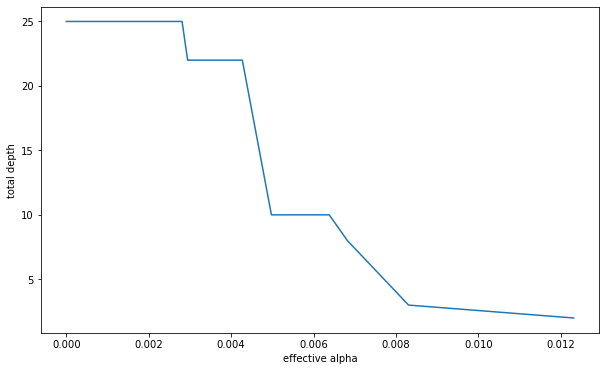

In [27]:
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths)
plt.xlabel("effective alpha")
plt.ylabel("total depth")

In [28]:
optimal_clf = clfs[np.argmax(dt_acc_list)]

train_acc = optimal_clf.score(X_train,y_train)
val_acc = optimal_clf.score(X_val, y_val)

print(f'Training Accuracy: {train_acc}')
print(f'Val Accuracy: {val_acc}')

Training Accuracy: 0.7300884955752213
Val Accuracy: 0.6597938144329897


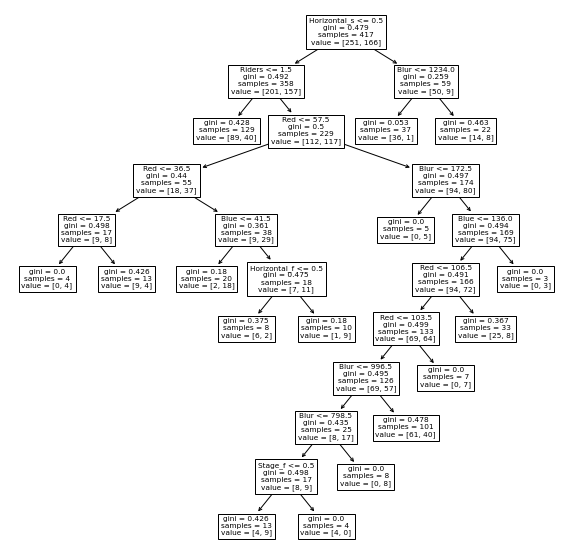

In [29]:
plt.figure(figsize=(10, 10))
plot_tree(optimal_clf, feature_names=X.columns)
plt.show()

# Random Forest
We will use a validation set to limit computational intensity. This increases the risk of overfitting the model, but this will be mitigated by checking the stability of the hyperperameters. Adjustments will be made in the case that the model was fit on hyperparameter values that performed better on the validation set likely due to chance.

First, set n_estimators to 1500 to fit and validate various max_depth values.

In [30]:
rfs_md = []
rfs_md_acc = []
for i in range(1,23):
    rf = RandomForestClassifier(n_estimators=1500,
                            max_depth=i,
                            oob_score=True,
                            random_state=50)
    rf.fit(X_train,y_train)
    rfs_md.append(rf)
    rfs_md_acc.append(rf.score(X_val, y_val))

<ipython-input-30-8a96e84c2361>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train,y_train)
<ipython-input-30-8a96e84c2361>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train,y_train)
<ipython-input-30-8a96e84c2361>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train,y_train)
<ipython-input-30-8a96e84c2361>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train,y_train)
<ipython-input-30-8a96e84c2361>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

In [31]:
opt_md = rfs_md[np.argmax(rfs_md_acc)].max_depth
opt_md

15

Fit fodel with the optimal max_depth, and display validation accuracy.

In [32]:
rf = RandomForestClassifier(n_estimators=1500,
                        max_depth=opt_md,
                        oob_score=True,
                        random_state=50)
opt_rf = rf.fit(X_train,y_train)

<ipython-input-32-0077d6d7201c>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  opt_rf = rf.fit(X_train,y_train)


In [33]:
print("Validation accuracy for Random Forest:", opt_rf.score(X_val, y_val))

Validation accuracy for Random Forest: 0.6907216494845361


Using the optimal max_depth value, iterate through various n_estimator values, selecting the optimal.

In [34]:
rfs = []
rfs_n_est_acc = []
for i in range(1000,2000,100):
    rf = RandomForestClassifier(n_estimators=i,
                            max_depth=12,
                            oob_score=True,
                            random_state=50)
    rf.fit(X_train,y_train)
    rfs.append(rf)
    rfs_n_est_acc.append(rf.score(X_val, y_val))

<ipython-input-34-afef6634152f>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train,y_train)
<ipython-input-34-afef6634152f>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train,y_train)
<ipython-input-34-afef6634152f>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train,y_train)
<ipython-input-34-afef6634152f>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train,y_train)
<ipython-input-34-afef6634152f>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

Fit fodel with the optimal max_depth and n_estimators, and display validation accuracy.

In [35]:
opt_n_estimators = rfs[np.argmax(rfs_n_est_acc)].n_estimators
opt_n_estimators

1100

In [36]:
print("Validation accuracy for Random Forest:", opt_rf.score(X_val, y_val))

Validation accuracy for Random Forest: 0.6907216494845361


In [37]:
rf = RandomForestClassifier(n_estimators=opt_n_estimators,
                        max_depth=opt_md,
                        oob_score=True,
                        random_state=50)
opt_rf = rf.fit(X_train,y_train)

<ipython-input-37-87284c1ae7b9>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  opt_rf = rf.fit(X_train,y_train)


Check the stability of the random forest's hyperparameters to make sure the model is not overfit, and will generalize well to new data. This will be important because I did not do the more comprehensive cross-validation process.

Text(0.5, 0, 'N_Estimators')

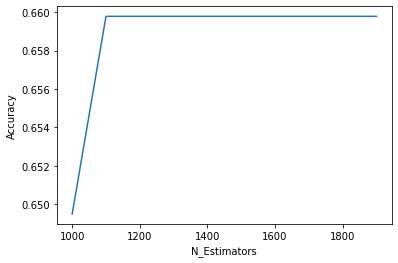

In [38]:
rf_n_est = []
rf_scores = []

for rf in rfs:
    rf_n_est.append(rf.n_estimators)
    rf_scores.append(rf.score(X_val, y_val))

plt.plot(np.arange(min(rf_n_est), max(rf_n_est) + 1, 100), rf_scores)
plt.ylabel("Accuracy")
plt.xlabel("N_Estimators")

Text(0.5, 0, 'Max Depth')

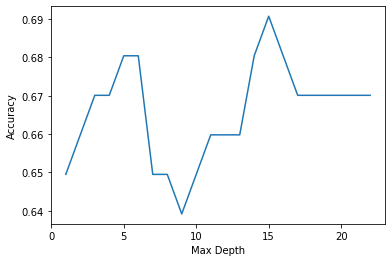

In [39]:
max_depths = []

for rf in rfs_md:
    max_depths.append(rf.max_depth)

plt.plot(np.arange(min(max_depths), max(max_depths) + 1, 1), rfs_md_acc)
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")

The hyperparameters are clearly set at peaks, which means the model will be more likely to be overfit to the data.

n_estimators = 1600 and max_depth = 5 appears to be more stable. I will use these values.

In [61]:
rf = RandomForestClassifier(n_estimators=1600,
                        max_depth=5,
                        oob_score=True,
                        random_state=50)
opt_rf = rf.fit(X_train,y_train)

<ipython-input-61-71c7d20b3c87>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  opt_rf = rf.fit(X_train,y_train)


In [41]:
print("Validation accuracy for Random Forest:", opt_rf.score(X_val, y_val))

Validation accuracy for Random Forest: 0.6701030927835051


They still performed well on the validation set when paired together. We will keep this as the final random forest model.

In [104]:
params_grid = [{'kernel': ['linear'], 'C': [1, 10]}]

In [105]:
lin_svm_model = GridSearchCV(SVC(), params_grid, cv=5, n_jobs=-1, verbose=4)
lin_svm_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\light\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10], 'kernel': ['linear']}], verbose=4)

In [106]:
lin_svm_model.cv_results_

{'mean_fit_time': array([0.02669754, 0.04543467]),
 'std_fit_time': array([0.00410974, 0.02145689]),
 'mean_score_time': array([0.0085217 , 0.00377498]),
 'std_score_time': array([0.00360758, 0.00571453]),
 'param_C': masked_array(data=[1, 10],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['linear', 'linear'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'kernel': 'linear'}, {'C': 10, 'kernel': 'linear'}],
 'split0_test_score': array([0.6043956 , 0.61538462]),
 'split1_test_score': array([0.56043956, 0.54945055]),
 'split2_test_score': array([0.64444444, 0.63333333]),
 'split3_test_score': array([0.61111111, 0.63333333]),
 'split4_test_score': array([0.58888889, 0.6       ]),
 'mean_test_score': array([0.60185592, 0.60630037]),
 'std_test_score': array([0.02752944, 0.03103444]),
 'rank_test_score': array([2, 1])}

In [107]:
print('Best score for training data:', lin_svm_model.best_score_)

Best score for training data: 0.6063003663003663


Try an RBF SVM. Ran these separately to monitor run time.

In [117]:
params_grid = [{'kernel': ['rbf'], 'C': [0, .5, 1, 5]}]

In [118]:
rbf_svm_model = GridSearchCV(SVC(), params_grid, cv=5, n_jobs=-1, verbose=4)
rbf_svm_model.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\light\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\light\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\light\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 251, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\light\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 333, in _dense_fit
    ) = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", l

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0, 0.5, 1, 5], 'kernel': ['rbf']}], verbose=4)

In [119]:
rbf_svm_model.cv_results_

{'mean_fit_time': array([0.0097014 , 0.02414069, 0.02373595, 0.01784544]),
 'std_fit_time': array([0.00231541, 0.00266821, 0.0007845 , 0.00347559]),
 'mean_score_time': array([0.        , 0.01091261, 0.01176863, 0.00743999]),
 'std_score_time': array([0.        , 0.00196624, 0.00543385, 0.0049256 ]),
 'param_C': masked_array(data=[0, 0.5, 1, 5],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'rbf', 'rbf', 'rbf'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0, 'kernel': 'rbf'},
  {'C': 0.5, 'kernel': 'rbf'},
  {'C': 1, 'kernel': 'rbf'},
  {'C': 5, 'kernel': 'rbf'}],
 'split0_test_score': array([       nan, 0.59340659, 0.54945055, 0.53846154]),
 'split1_test_score': array([       nan, 0.58241758, 0.59340659, 0.57142857]),
 'split2_test_score': array([       nan, 0.6       , 0.65555556, 0.6       ]),
 'split3_test_score

In [120]:
print('Best score for training data:', rbf_svm_model.best_score_)

Best score for training data: 0.5952380952380952


The Radial Basis Function Support Vector Machine did slightly worse than the linear kearnel did and both models did not surpass the Majority Class Classifier on their training set. It is not worth running these models on the validation or test sets.

Here we will display the validation accuracies for each final model.

In [62]:
predictors = models_fwd.loc[np.argmax(models_fwd['acc']) + 1, 'model'].model.exog_names
preds = log_reg.predict(X_val[predictors])

binary_preds = np.where(preds >= thresholds[np.argmax(acc_list)], 1, 0)

print("Validation Set Accuracies")
print("Logistic Regression:", accuracy_score(y_val, binary_preds))
print("Decision Tree:", optimal_clf.score(X_val, y_val))
print("Random Forest:", opt_rf.score(X_val, y_val))

Validation Set Accuracies
Logistic Regression: 0.6701030927835051
Decision Tree: 0.6597938144329897
Random Forest: 0.6804123711340206


The Random Forest and Logistic regression performed highly on the validation set. I would chose the Random Forest to predict the BuyRating on future photos because of its ability to generalize well to new data. The Logistic Regression clearly shows what is better in a photo, which can be implemented into the training of new photographers. The decision tree and the SVM's can be completely scrapped in this instance.

In [122]:
print("Random Forest predictive accuracy on test set: ", opt_rf.score(X_test, y_test))

Random Forest predictive accuracy on test set:  0.6804123711340206


While there are less downloads than non-downloads, the imbalance is not significant. There is no difference between the consequence of false negatives and false positives. For these reasons, I have chosen to use accuracy as the measurement of model quality.